# Models Comparison for TinyML

In [1]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
labels = 5
samples = 100
X = X[:labels*samples]
y = y[:labels*samples]

In [5]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [7]:
scaler = RobustScaler()

In [8]:
X_test.shape

(100, 32)

In [9]:
y = np.array(y)


## Model Spotting

In [10]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'

In [11]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [12]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_train = scaler.fit_transform(X_cross_train)
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        X_cross_test = scaler.transform(X_cross_test)
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,35 0,06
LR - 0,45 0,07
CART - 0,49 0,07
SVC - 0,61 0,06
RF - 0,63 0,06


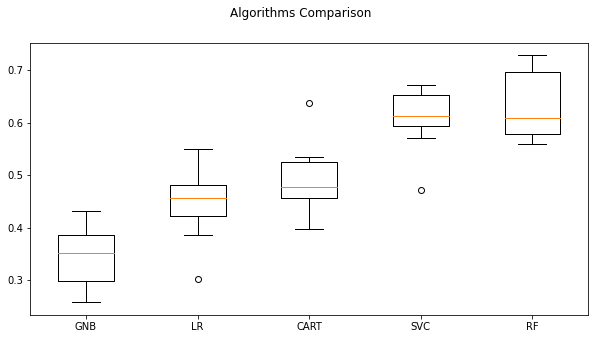

In [13]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Valutazione modelli sul Test Set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    print(classification_report(y_test, pred_test))
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.93      0.70      0.80        20
           2       0.37      0.95      0.53        20
           3       1.00      0.10      0.18        20
           4       0.37      0.55      0.44        20

    accuracy                           0.46       100
   macro avg       0.53      0.46      0.39       100
weighted avg       0.53      0.46      0.39       100

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.56      0.70      0.62        20
           1       0.79      0.75      0.77        20
           2       0.58      0.35      0.44        20
           3       0.43      0.60      0.50        20
           4       0.44      0.35      0.39        20

    accuracy                           0.55       100
   macro avg       0.56      0.55      0.54   

# Valutazione Inferance Rate medio (|X_test| = 40)

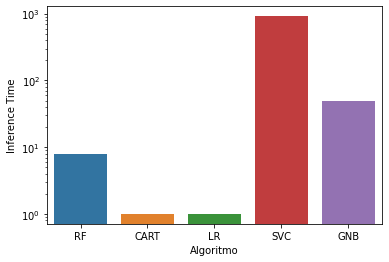

In [316]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

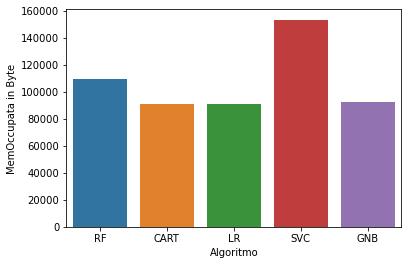

In [20]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Sequential Neural Network

In [15]:
model = Sequential(name="Sequential-NN")
model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(np.unique(y).size * 4, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(np.unique(y).size, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
y_train = np.array([int(num) for num in y_train])

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________


## Train and Test

In [16]:
EPOCHS = 1000
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/1000
13/13 [==============================] - 0s 618us/step - loss: 1.9580 - accuracy: 0.2050
Epoch 2/1000
13/13 [==============================] - 0s 769us/step - loss: 1.7120 - accuracy: 0.1950
Epoch 3/1000
13/13 [==============================] - 0s 692us/step - loss: 1.6372 - accuracy: 0.2700
Epoch 4/1000
13/13 [==============================] - 0s 538us/step - loss: 1.5667 - accuracy: 0.3250
Epoch 5/1000
13/13 [==============================] - 0s 615us/step - loss: 1.5519 - accuracy: 0.3025
Epoch 6/1000
13/13 [==============================] - 0s 615us/step - loss: 1.5002 - accuracy: 0.3525
Epoch 7/1000
13/13 [==============================] - 0s 692us/step - loss: 1.5147 - accuracy: 0.3425
Epoch 8/1000
13/13 [==============================] - 0s 846us/step - loss: 1.4671 - accuracy: 0.3925
Epoch 9/1000
13/13 [==============================] - 0s 923us/step - loss: 1.4306 - accuracy: 0.3725
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.3725 

13/13 [==============================] - 0s 692us/step - loss: 0.8392 - accuracy: 0.6850
Epoch 159/1000
13/13 [==============================] - 0s 616us/step - loss: 0.7717 - accuracy: 0.7300
Epoch 160/1000
13/13 [==============================] - 0s 615us/step - loss: 0.8202 - accuracy: 0.7050
Epoch 161/1000
13/13 [==============================] - 0s 692us/step - loss: 0.7973 - accuracy: 0.6975
Epoch 162/1000
13/13 [==============================] - 0s 769us/step - loss: 0.7782 - accuracy: 0.7075
Epoch 163/1000
13/13 [==============================] - 0s 538us/step - loss: 0.8483 - accuracy: 0.7000
Epoch 164/1000
13/13 [==============================] - 0s 692us/step - loss: 0.7521 - accuracy: 0.7250
Epoch 165/1000
13/13 [==============================] - 0s 538us/step - loss: 0.8127 - accuracy: 0.7300
Epoch 166/1000
13/13 [==============================] - 0s 692us/step - loss: 0.7389 - accuracy: 0.7375
Epoch 167/1000
13/13 [==============================] - 0s 692us/step - loss: 0

13/13 [==============================] - 0s 692us/step - loss: 0.6565 - accuracy: 0.7875
Epoch 315/1000
13/13 [==============================] - 0s 692us/step - loss: 0.6049 - accuracy: 0.7650
Epoch 316/1000
13/13 [==============================] - 0s 538us/step - loss: 0.6226 - accuracy: 0.7825
Epoch 317/1000
13/13 [==============================] - 0s 615us/step - loss: 0.6462 - accuracy: 0.7725
Epoch 318/1000
13/13 [==============================] - 0s 538us/step - loss: 0.6087 - accuracy: 0.7875
Epoch 319/1000
13/13 [==============================] - 0s 615us/step - loss: 0.6504 - accuracy: 0.7725
Epoch 320/1000
13/13 [==============================] - 0s 615us/step - loss: 0.5841 - accuracy: 0.7975
Epoch 321/1000
13/13 [==============================] - 0s 615us/step - loss: 0.6035 - accuracy: 0.7900
Epoch 322/1000
13/13 [==============================] - 0s 692us/step - loss: 0.6436 - accuracy: 0.7425
Epoch 323/1000
13/13 [==============================] - 0s 615us/step - loss: 0

13/13 [==============================] - 0s 692us/step - loss: 0.5514 - accuracy: 0.8075
Epoch 471/1000
13/13 [==============================] - 0s 615us/step - loss: 0.5476 - accuracy: 0.8075
Epoch 472/1000
13/13 [==============================] - 0s 614us/step - loss: 0.5149 - accuracy: 0.8325
Epoch 473/1000
13/13 [==============================] - 0s 538us/step - loss: 0.5194 - accuracy: 0.8275
Epoch 474/1000
13/13 [==============================] - 0s 693us/step - loss: 0.5433 - accuracy: 0.8200
Epoch 475/1000
13/13 [==============================] - 0s 615us/step - loss: 0.5535 - accuracy: 0.8100
Epoch 476/1000
13/13 [==============================] - 0s 615us/step - loss: 0.4896 - accuracy: 0.8300
Epoch 477/1000
13/13 [==============================] - 0s 539us/step - loss: 0.5150 - accuracy: 0.8175
Epoch 478/1000
13/13 [==============================] - 0s 538us/step - loss: 0.4750 - accuracy: 0.8200
Epoch 479/1000
13/13 [==============================] - 0s 615us/step - loss: 0

13/13 [==============================] - 0s 692us/step - loss: 0.4896 - accuracy: 0.8275
Epoch 627/1000
13/13 [==============================] - 0s 615us/step - loss: 0.4757 - accuracy: 0.8500
Epoch 628/1000
13/13 [==============================] - 0s 615us/step - loss: 0.4457 - accuracy: 0.8475
Epoch 629/1000
13/13 [==============================] - 0s 592us/step - loss: 0.4005 - accuracy: 0.8600
Epoch 630/1000
13/13 [==============================] - 0s 616us/step - loss: 0.4402 - accuracy: 0.8300
Epoch 631/1000
13/13 [==============================] - 0s 615us/step - loss: 0.4724 - accuracy: 0.8450
Epoch 632/1000
13/13 [==============================] - 0s 615us/step - loss: 0.4669 - accuracy: 0.8400
Epoch 633/1000
13/13 [==============================] - 0s 539us/step - loss: 0.4592 - accuracy: 0.8225
Epoch 634/1000
13/13 [==============================] - 0s 615us/step - loss: 0.4496 - accuracy: 0.8475
Epoch 635/1000
13/13 [==============================] - 0s 692us/step - loss: 0

13/13 [==============================] - 0s 615us/step - loss: 0.3886 - accuracy: 0.8575
Epoch 783/1000
13/13 [==============================] - 0s 538us/step - loss: 0.4060 - accuracy: 0.8575
Epoch 784/1000
13/13 [==============================] - 0s 692us/step - loss: 0.4072 - accuracy: 0.8650
Epoch 785/1000
13/13 [==============================] - 0s 538us/step - loss: 0.3950 - accuracy: 0.8700
Epoch 786/1000
13/13 [==============================] - 0s 692us/step - loss: 0.4375 - accuracy: 0.8450
Epoch 787/1000
13/13 [==============================] - 0s 538us/step - loss: 0.3838 - accuracy: 0.8650
Epoch 788/1000
13/13 [==============================] - 0s 692us/step - loss: 0.4301 - accuracy: 0.8700
Epoch 789/1000
13/13 [==============================] - 0s 614us/step - loss: 0.3842 - accuracy: 0.8800
Epoch 790/1000
13/13 [==============================] - 0s 693us/step - loss: 0.3881 - accuracy: 0.8650
Epoch 791/1000
13/13 [==============================] - 0s 538us/step - loss: 0

13/13 [==============================] - 0s 538us/step - loss: 0.3210 - accuracy: 0.8950
Epoch 939/1000
13/13 [==============================] - 0s 692us/step - loss: 0.3946 - accuracy: 0.8800
Epoch 940/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3627 - accuracy: 0.8600
Epoch 941/1000
13/13 [==============================] - 0s 538us/step - loss: 0.3795 - accuracy: 0.8625
Epoch 942/1000
13/13 [==============================] - 0s 537us/step - loss: 0.3642 - accuracy: 0.8525
Epoch 943/1000
13/13 [==============================] - 0s 616us/step - loss: 0.3612 - accuracy: 0.8800
Epoch 944/1000
13/13 [==============================] - 0s 538us/step - loss: 0.3914 - accuracy: 0.8750
Epoch 945/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3713 - accuracy: 0.8750
Epoch 946/1000
13/13 [==============================] - 0s 616us/step - loss: 0.3239 - accuracy: 0.8875
Epoch 947/1000
13/13 [==============================] - 0s 615us/step - loss: 0

In [17]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)

Text(0, 0.5, 'Loss')

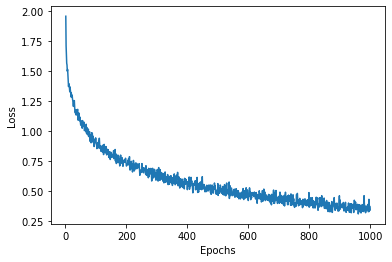

In [18]:
loss = history.history['loss']
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

[3 2 0 0 0 3 1 2 3 4 4 1 1 4 3 2 3 0 2 1 1 4 1 2 0 4 2 1 2 1 4 4 4 2 0 2 3
 3 1 4 0 3 1 4 2 0 4 0 0 1 3 3 0 2 2 2 4 1 0 2 3 2 3 3 4 3 1 4 1 4 3 2 4 3
 3 4 4 3 3 4 1 1 1 0 4 3 0 2 3 3 0 0 4 0 1 2 1 0 2 2]


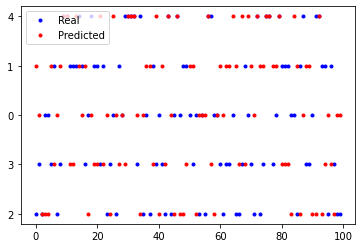

In [31]:
x = np.arange(X_test.shape[0])
plt.clf()
plt.plot(x, y_test, 'b.', label="Real")
plt.plot(x, predictions_categorical, 'r.', label="Predicted")
plt.legend()
plt.show()

# Export Models in C code

In [21]:
for name, model in models:
    prepath = 'exportedModels/' + str(labels) + "/"
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    print(type(x))
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
